In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from modules.loader import ImmothepDataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

loader = ImmothepDataLoader()

DATASET_PATH = '../datas/CURATED/'

%load_ext autoreload
%autoreload 2

In [2]:
loader.ensure_data_loaded()

Les fichiers sont correctement téléchargés


In [44]:
extrait_df_valeurs_foncieres = pd.read_csv(DATASET_PATH + "maison_filtre.csv", sep=',', usecols=['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain', 'Code postal'], encoding='utf-8')

In [47]:
#data = [[str(1160.0), str(90.0),  str(4.0),  str(940.0)], [str(1160.0), str(90.0),  str(4.0),  str(940.0)]] 
data = [[str(2000.0), str(120.0),  str(6.0),  str(99990.0)]] 
  
# Create the pandas DataFrame 
resultat = pd.DataFrame(data, columns = ['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain', 'Code postal'])


#print(X)
#print(y)

In [48]:
extrait_df_valeurs_foncieres.append(resultat)

,Code postal,Surface reelle bati,Nombre pieces principales,Surface terrain
0,1160,90,4,940
1,1370,101,5,490
2,1340,88,4,708
3,1340,115,4,1067
4,1310,123,4,1073
...,...,...,...,...
263498,97410,77,4,222
263499,97430,108,4,249
263500,97414,84,5,507
263501,97421,87,6,210


In [50]:
#print(extrait_df_valeurs_foncieres)
resultat.head()

,Code postal,Surface reelle bati,Nombre pieces principales,Surface terrain
0,1160.0,90.0,4.0,940.0
1,1370.0,101.0,5.0,490.0
2,1340.0,88.0,4.0,708.0
3,1340.0,115.0,4.0,1067.0
4,1310.0,123.0,4.0,1073.0


In [49]:
data = extrait_df_valeurs_foncieres.values
X = data[:, 1:]  # all rows, no label
y = data[:, 0]  # all rows, label only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

StandardScaler()

In [21]:

data2 = resultat.values
X = data2[:, 1:]  # all rows, no label
y = data2[:, 0]  # all rows, label only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#scaler = StandardScaler()
scaler.partial_fit(X_train)

AttributeError: &#39;numpy.ndarray&#39; object has no attribute &#39;append&#39;

In [25]:
print(X_train)

[[102.   4. 441.]
 [ 78.   4. 290.]
 [134.   5. 690.]
 ...
 [ 79.   4. 261.]
 [117.   5. 500.]
 [ 91.   4. 247.]]


In [42]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
estimator = SGDRegressor()
# estimator = LinearRegression()  # LinearRegression works with sparse matrix
estimator.fit(X_train, y_train)
predicted = estimator.predict(X_train)

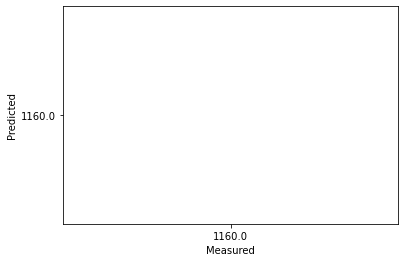

In [69]:

fig, ax = plt.subplots()
ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()